In [1]:
# Imports
import numpy as np
import uproot
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from xgboost import XGBClassifier

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score


### Functions

In [2]:
def load_data(file_path, columns, tree_name="tree_Hmumu"):
    """
    Load data from a ROOT file using uproot.
    """
    tree = uproot.open(file_path)[tree_name]
    df = tree.arrays(columns, library="pd")
    return df

def prepare_data(background_df, signal_df, shuffle=True):
    """
    Combine background and signal datasets, shuffle, and split into features, labels, weights.
    """
    df = pd.concat([background_df, signal_df], ignore_index=True)

    if shuffle:
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    x = df.drop(["Binary_Target", "weight"], axis=1)
    y = df["Binary_Target"]
    weight = df["weight"].to_numpy()

    return x, y, weight

def split_and_scale(X, y, weight, test_size=0.2):
    """
    Split the dataset and apply standard scaling.
    """
    X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
        X, y, weight, test_size=test_size, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, weight_train, weight_test, scaler

def train_xgboost(X_train, y_train):
    """
    Train an XGBoost classifier.
    """
    model = XGBClassifier(eval_metric="logloss", random_state=42)

    model.fit(X_train, y_train)
    return model

def plot_confusion_matrix(y_true, y_pred, labels=["Background", "Signal"]):
    """
    Plot a normalized confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(6, 6))
    # disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True, values_format=".2f")
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False, values_format=".2f")
    ax.set_title("Normalized Confusion Matrix")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()


def plot_roc_curve(model, X_test, y_test):
    """
    Plot ROC curve for binary classifier.
    """
    # Predict probabilities
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def plot_binned_background_shape(
    model,
    X_test_scaled,
    y_test,
    weight,
    scaler,
    mass_index=14,
    bins=np.linspace(110, 160, 80),
    score_bins=[(0.00, 0.34), (0.34, 0.68), (0.68, 0.9), (0.9, 1.0)],
    colors=["blue", "orange", "green", "red"],
    higgs_mass=125
):
    """
    Plot binned dimuon mass distribution for background events,
    separated by classifier score bins, with exponential background fit.
    """

    # Get predicted signal probabilities
    probs = model.predict_proba(X_test_scaled)[:, 1]

    # Unscale to retrieve dimuon mass
    m_mumu = scaler.inverse_transform(X_test_scaled)[:, mass_index]

    # Ensure proper array types
    y_test = np.asarray(y_test)
    weight = np.asarray(weight)

    # Select background events
    mask_bkg = y_test == 0
    scores = probs[mask_bkg]
    masses = m_mumu[mask_bkg]
    weights_bkg = weight[mask_bkg]

    # Setup bins and labels
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    labels = [f"{low:.2f} ≤ Score < {high:.2f}" for (low, high) in score_bins]

    plt.figure(figsize=(9, 6))

    # Plot histograms by classifier score
    for (low, high), color, label in zip(score_bins, colors, labels):
        mask = (scores >= low) & (scores < high)
        hist, _ = np.histogram(masses[mask], bins=bins, weights=weights_bkg[mask], density=True)
        plt.step(bin_centers, hist, where="mid", color=color, label=label)

    # Full background shape and fit
    hist_all, _ = np.histogram(masses, bins=bins, weights=weights_bkg, density=True)
    try:
        popt, _ = curve_fit(exp_decay, bin_centers, hist_all, p0=(1, 0.1, 0))
        smoothed = exp_decay(bin_centers, *popt)
        plt.plot(bin_centers, smoothed, 'k--', label="Fitted Background Shape")
    except RuntimeError:
        print("⚠️ Background fit failed. Skipping fit curve.")

    # Higgs mass line
    plt.axvline(higgs_mass, color="gray", linestyle=":", label="Higgs Mass")

    # Final styling
    plt.xlabel(r"$M_{\mu\mu}$ [GeV]")
    plt.ylabel("Fraction of events")
    plt.title("Background Shape by Classifier Score")
    plt.legend(title="Score Bins")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Load in data and prepare for training

In [3]:
# Columns used in the model training
COLUMNS = [
    'Jets_PT_Lead', 'Jets_PT_Sub',
    'Jets_Phi_Lead', 'Jets_Phi_Sub',
    'Jets_E_Lead', 'Jets_E_Sub',
    'Jets_Eta_Lead', 'Jets_Eta_Sub',
    'Muons_PT_Lead', 'Muons_PT_Sub',
    'Muons_Phi_Lead', 'Muons_Phi_Sub',
    'Muons_Eta_Lead', 'Muons_Eta_Sub',
    'Muons_Minv_MuMu_Fsr',
    'weight',
    'Binary_Target'
]

# Load the data
background_df = load_data("Background.root", COLUMNS)
signal_df = load_data("Signal.root", COLUMNS)

# Prepare the data
x_val, y_val, weight = prepare_data(background_df, signal_df)

# Split and scale
X_train, X_test, y_train, y_test, weight_train, weight_test, scale = split_and_scale(x_val, y_val, weight)

### Train Model and Visualize Results

✅ Accuracy: 0.8983757251784454


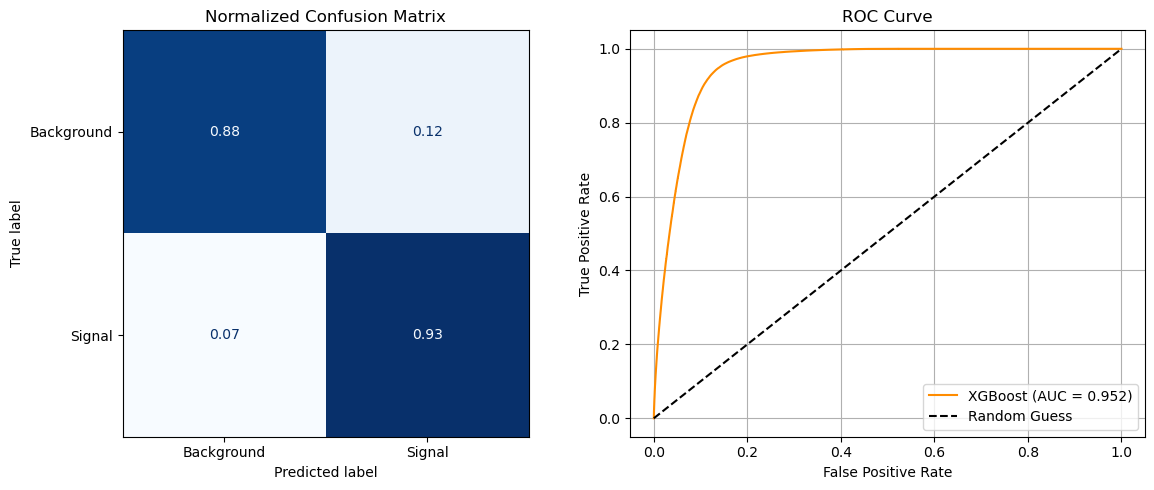

C:\Users\barts\AppData\Local\Temp\ipykernel_27224\3804008175.py:87: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
C:\Users\barts\AppData\Local\Temp\ipykernel_27224\3804008175.py:87: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


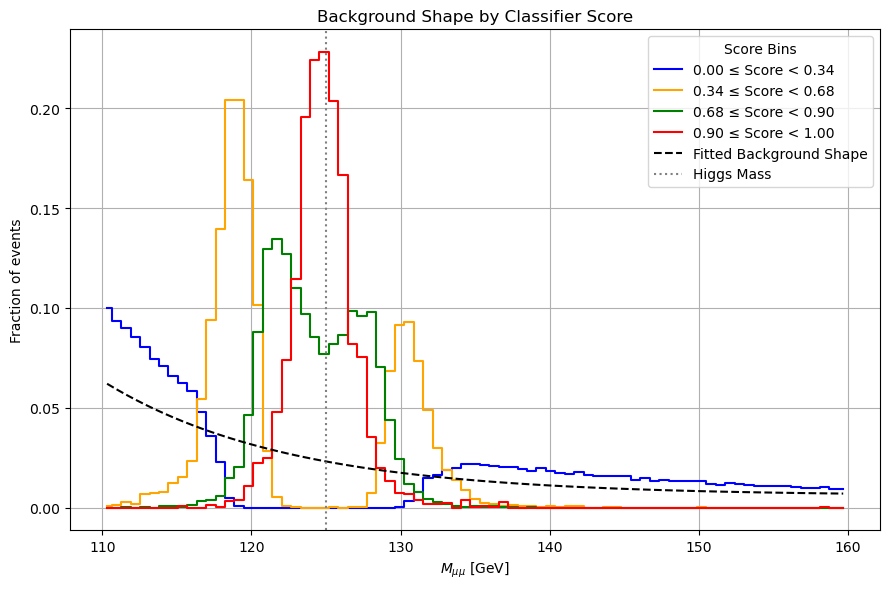

In [4]:
# Train model
model = train_xgboost(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# Start plotting side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Signal"])
disp.plot(ax=ax1, cmap=plt.cm.Blues, colorbar=False, values_format=".2f")
ax1.set_title("Normalized Confusion Matrix")

# --- ROC Curve ---
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)
ax2.plot(fpr, tpr, label=f"XGBoost (AUC = {auc:.3f})", color="darkorange")
ax2.plot([0, 1], [0, 1], 'k--', label="Random Guess")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve")
ax2.legend(loc="lower right")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Plot binned background shape
plot_binned_background_shape(
    model=model,
    X_test_scaled=X_test,
    y_test=y_test,
    weight=weight_test,
    scaler=scale
)

### Run without Mass

In [5]:
def prepare_data_without_mass(background_df, signal_df, shuffle=True):
    """
    Combine background and signal datasets, shuffle, and split into features, labels, weights, and mass.
    """
    df = pd.concat([background_df, signal_df], ignore_index=True)

    if shuffle:
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Extract and drop target columns
    x = df.drop(["Binary_Target", "Muons_Minv_MuMu_Fsr", "weight"], axis=1)
    y = df["Binary_Target"]
    weight = df["weight"].to_numpy()
    mass = df["Muons_Minv_MuMu_Fsr"].to_numpy()

    return x, y, weight, mass

def split_and_scale_without_mass(X, y, weight, mass, test_size=0.2):
    """
    Split the dataset and apply standard scaling (not on mass).
    """
    X_train, X_test, y_train, y_test, weight_train, weight_test, mass_train, mass_test = train_test_split(
        X, y, weight, mass, test_size=test_size, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, weight_train, weight_test, mass_train, mass_test, scaler

def plot_binned_background_shape_without_mass(
    model,
    X_test_scaled,
    y_test,
    weight,
    mass_test,
    score_bins=None,
    score_intervals=4,
    colors=None,
    bins=np.linspace(110, 160, 80),
    higgs_mass=125
):
    """
    Plot binned dimuon mass distribution for background events,
    separated by classifier score bins, with exponential background fit.
    """

    # Predict probabilities
    probs = model.predict_proba(X_test_scaled)[:, 1]

    # Select background events
    mask_bkg = y_test == 0
    scores = probs[mask_bkg]
    masses = mass_test[mask_bkg]
    weights_bkg = weight[mask_bkg]

    # Auto-generate score bins if not provided
    if score_bins is None:
        edges = np.linspace(0, 1, score_intervals + 1)
        score_bins = list(zip(edges[:-1], edges[1:]))

    # Default colors
    if colors is None:
        color_map = plt.cm.get_cmap("tab10")
        colors = [color_map(i) for i in range(len(score_bins))]

    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    labels = [f"{low:.2f} ≤ Score < {high:.2f}" for (low, high) in score_bins]

    plt.figure(figsize=(9, 6))

    for (low, high), color, label in zip(score_bins, colors, labels):
        mask = (scores >= low) & (scores < high)
        hist, _ = np.histogram(masses[mask], bins=bins, weights=weights_bkg[mask], density=True)
        plt.step(bin_centers, hist, where="mid", color=color, label=label)

    # Fit full background shape
    hist_all, _ = np.histogram(masses, bins=bins, weights=weights_bkg, density=True)
    try:
        popt, _ = curve_fit(exp_decay, bin_centers, hist_all, p0=(1, 0.1, 0))
        smoothed = exp_decay(bin_centers, *popt)
        plt.plot(bin_centers, smoothed, 'k--', label="Fitted Background Shape")
    except RuntimeError:
        print("⚠️ Background fit failed. Skipping fit curve.")

    plt.axvline(higgs_mass, color="gray", linestyle=":", label="Higgs Mass")
    plt.xlabel(r"$M_{\mu\mu}$ [GeV]")
    plt.ylabel("Fraction of events")
    plt.title("Background Shape by Classifier Score")
    plt.legend(title="Score Bins")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


✅ Accuracy: 0.6509201726065208


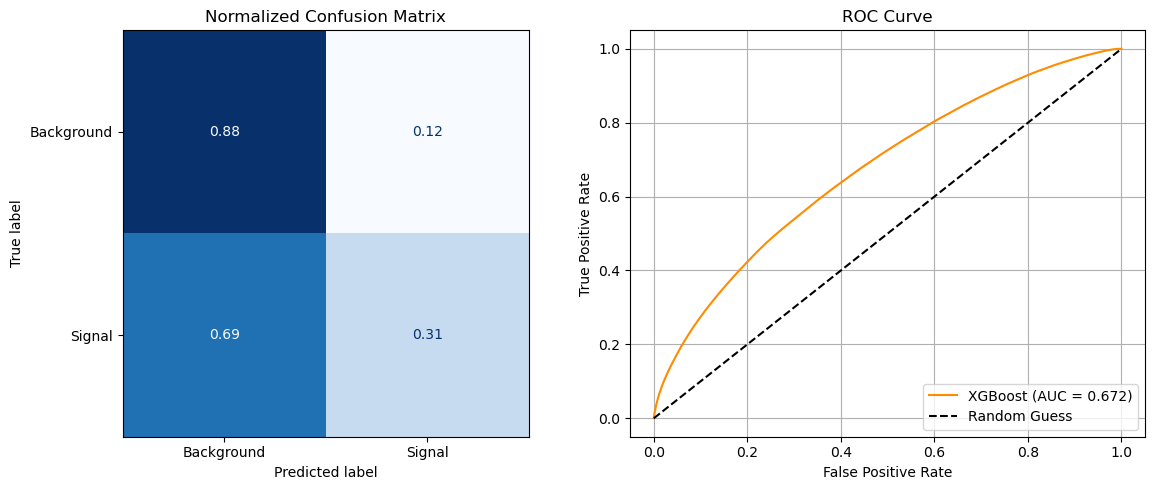

In [6]:
columns = [
    'Jets_Phi_Lead', 'Jets_Phi_Sub',
    'Jets_Eta_Lead', 'Jets_Eta_Sub',
    'Muons_Phi_Lead', 'Muons_Phi_Sub',
    'Muons_Eta_Lead', 'Muons_Eta_Sub',
    'Muons_Minv_MuMu_Fsr',
    'Binary_Target', 'weight'
]

# Load the data
background_df = load_data("Background.root", columns)
signal_df = load_data("Signal.root", columns)

# Prepare the data
x_val, y_val, weight, mass = prepare_data_without_mass(background_df, signal_df)

# Split and scale
X_train, X_test, y_train, y_test, weight_train, weight_test, mass_train, mass_test, scale = split_and_scale_without_mass(x_val, y_val, weight, mass)

# Train model
model = train_xgboost(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# Start plotting side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Signal"])
disp.plot(ax=ax1, cmap=plt.cm.Blues, colorbar=False, values_format=".2f")
ax1.set_title("Normalized Confusion Matrix")

# --- ROC Curve ---
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)
ax2.plot(fpr, tpr, label=f"XGBoost (AUC = {auc:.3f})", color="darkorange")
ax2.plot([0, 1], [0, 1], 'k--', label="Random Guess")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve")
ax2.legend(loc="lower right")
ax2.grid(True)

plt.tight_layout()
plt.show()

C:\Users\barts\AppData\Local\Temp\ipykernel_27224\2545410969.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("tab10")
C:\Users\barts\AppData\Local\Temp\ipykernel_27224\3804008175.py:87: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
C:\Users\barts\AppData\Local\Temp\ipykernel_27224\3804008175.py:87: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


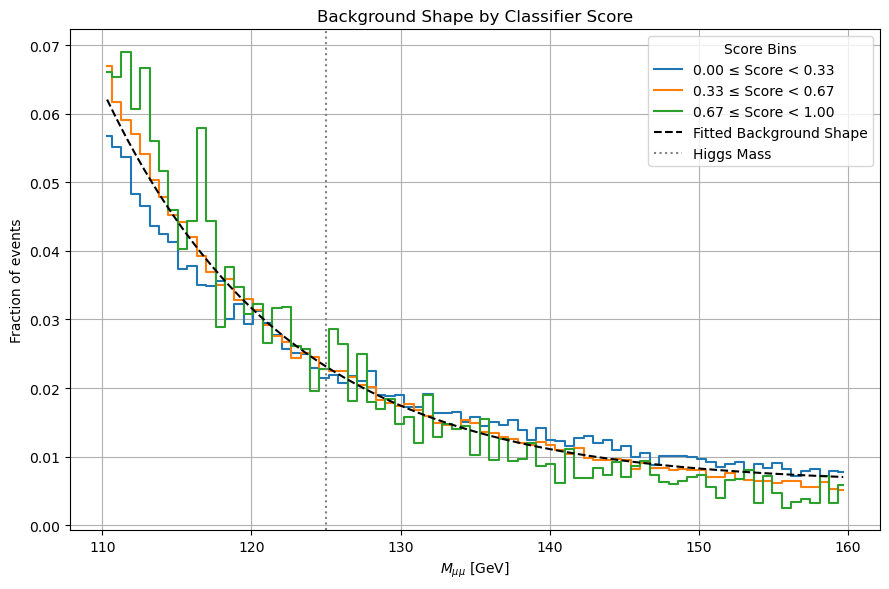

In [7]:
plot_binned_background_shape_without_mass(
    model, X_test, y_test, weight_test, mass_test,
    score_intervals=3
)